In [1]:
import random
import itertools as it
from pathlib import Path

import mido
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

from notepredictor import PitchPredictor, MIDIPitchDataset

In [29]:
# data_dir = Path('/Users/victor/Downloads/lmd_full')
# files = list(data_dir.glob('**/*.mid'))

In [30]:
# try:
#     mid = mido.MidiFile(random.choice(files))
# except Exception as e:
#     print(e, e.msg)
# tempos = {m.tempo for tr in mid.tracks for m in tr if m.type=='set_tempo'}
# tuple(tempos)[0] / mid.ticks_per_beat / 1e6
# mid.tracks[1]


In [2]:
data_dir = Path('/Users/victor/data/lmd_prep')

In [29]:
batch_size = 32
batch_len = 64

ds = MIDIPitchDataset(data_dir, batch_len)
dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, num_workers=0, collate_fn=torch.stack)

In [30]:
%%time
batch = next(iter(dl))
batch.shape

CPU times: user 21 ms, sys: 15.9 ms, total: 36.9 ms
Wall time: 61.7 ms


torch.Size([32, 64])

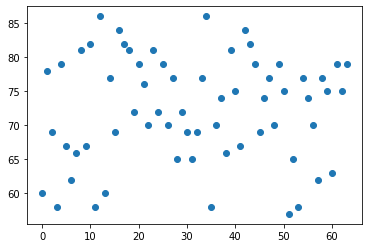

In [31]:
plt.scatter(range(batch.shape[1]), batch[7])

In [32]:
net = PitchPredictor(hidden_size=128, domain_size=130)

In [33]:
opt = torch.optim.Adam(net.parameters(), 1e-3)
losses = []

# train

512it [00:51,  9.91it/s]


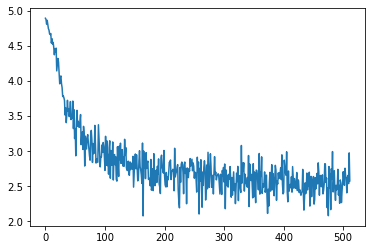

In [34]:
# %%prun

for batch in tqdm(it.islice(dl,512)):
    # batch = torch.LongTensor([notes for notes in it.islice(gen_tracks(batch_len), batch_size)])
    opt.zero_grad()
    r = net(batch)
    nll = (-r['log_probs']).mean()
    nll.backward()
    opt.step()
    losses.append(nll.item())
plt.plot(losses)

In [35]:
torch.save(net.state_dict(), 'pitch_lakh_16k.pt')

In [36]:
%%time
acc = 0
m = 64
ds_it = iter(ds)
for _ in range(m):
    notes = next(ds_it)
    n = len(notes)-1
    net.reset()
    acc += sum(net.predict(notes[i])==notes[i+1] for i in range(n))/n
acc/m

CPU times: user 1.15 s, sys: 53.6 ms, total: 1.21 s
Wall time: 1.31 s


tensor(0.1550)

In [37]:
batch_size*len(losses) / len(ds.files)

0.13836201800462783

In [56]:
torch.device('cuda:0').

'cuda'

In [38]:
%%timeit
net.predict(0)

197 µs ± 4.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# unigram baseline

first, visualize the model's unigram probabilities:


In [39]:
net_probs = []
for a in range(130):
    net.reset()
    b = net.predict(a, sample=False)
    net_probs.append(b)
net_probs = torch.stack(net_probs, 0)

Text(0.5, 1.0, 'log P(b|a)')

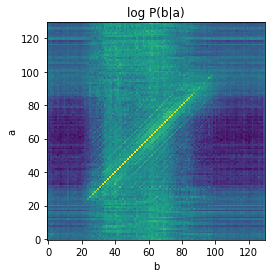

In [44]:
plt.imshow(net_probs.data.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(b|a)')

compute unigram proabilities over the data:

In [24]:
counts = torch.zeros(130,130).long()
for s in tqdm(ds):
    counts[s[:-1], s[1:]] += 1

100%|██████████| 118414/118414 [03:01<00:00, 652.77it/s]


Text(0.5, 1.0, 'log P(b|a)')

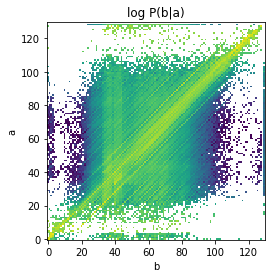

In [43]:
#P(b|a)
probs = counts / counts.sum(1,keepdims=True)
probs
plt.imshow(probs.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(b|a)')

<BarContainer object of 128 artists>

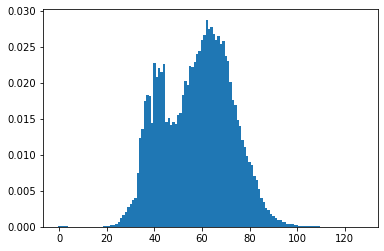

In [51]:
#ignoring start/stop tokens
marg = counts[:128].sum(1) / counts[:128].sum()
plt.bar(range(128), marg, width=1)

In [52]:
# baseline accuracy
(probs[:128, :128].max(1).values * marg).sum()

tensor(0.0723)

<BarContainer object of 130 artists>

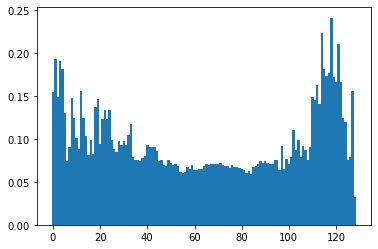

In [28]:
plt.bar(range(130), probs.max(1).values, width=1)

### bigrams

In [62]:
counts = torch.zeros(130,130,130).long()
for s in tqdm(ds):
    counts[s[:-2], s[1:-1], s[2:]] += 1

100%|██████████| 118414/118414 [03:03<00:00, 645.41it/s]


Text(0.5, 1.0, 'log P(c|a=60,b)')

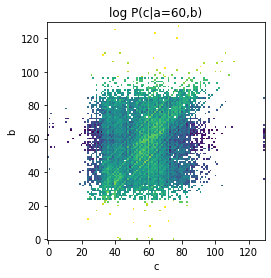

In [64]:
#P(c|a,b)
probs = counts / counts.sum(-1,keepdims=True)
plt.imshow(probs[60].log(), origin='lower', interpolation='nearest')
plt.ylabel('b')
plt.xlabel('c')
plt.title('log P(c|a=60,b)')

Text(0.5, 1.0, 'log P(a,b)')

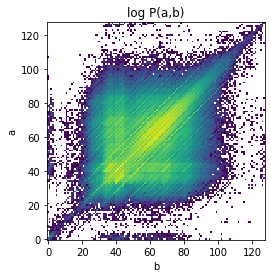

In [65]:
#ignoring start/stop tokens
marg = counts[:128, :128].sum(-1) / counts[:128, :128].sum()
plt.imshow(marg.log(), origin='lower', interpolation='nearest')
plt.ylabel('a')
plt.xlabel('b')
plt.title('log P(a,b)')

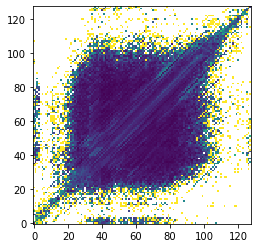

In [71]:
plt.imshow(probs[:128, :128].max(-1).values, origin='lower', interpolation='nearest')

In [74]:
# baseline accuracy
(probs[:128, :128].max(-1).values.nan_to_num(0) * marg).sum()

tensor(0.1371)